# Spanish ULMFiT from scratch (backwards)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.callbacks import SaveModelCallback
from lib.metrics import f1

In [2]:
bs=96

In [3]:
data_path = Config.data_path()
lang = 'es'
name = f'{lang}wiki'
path = data_path/name
dest = path/'docs'
lm_fns = [f'{lang}_wt_bwd', f'{lang}_wt_vocab_bwd']

## Spanish wikipedia model

In [4]:
# data = (TextList.from_folder(dest)
#             .split_by_rand_pct(0.1, seed=42)
#             .label_for_lm()
#             .databunch(bs=bs, num_workers=1, backwards=True))

# data.save(f'{lang}_databunch_bwd')

In [5]:
data = load_data(dest, f'{lang}_databunch_bwd', bs=bs, backwards=True)

In [6]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()

In [7]:
learn.lr_find(start_lr=1e-3, end_lr=1e1-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


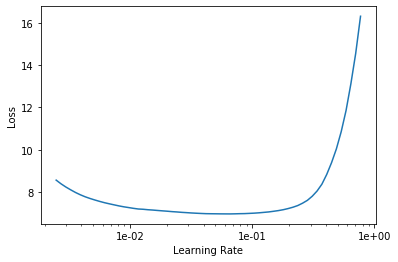

In [8]:
learn.recorder.plot()

In [9]:
lr = 1e-2
# lr *= bs/48  # Scale learning rate by batch size

In [10]:
learn.unfreeze()
# learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,accuracy,time
0,3.444012,3.411050,0.423217,3:31:34
1,3.573076,3.526484,0.411462,3:31:09
2,3.572197,3.566270,0.407482,3:30:57
3,3.544393,3.556223,0.408801,3:32:01
4,3.571290,3.522106,0.412222,3:36:52
5,3.512694,3.457823,0.418018,3:31:02
6,3.441303,3.388884,0.424103,3:31:20
7,3.370762,3.299700,0.433455,3:30:58
8,3.321628,3.212045,0.442560,3:29:54
9,3.300446,3.176915,0.446884,3:31:57


In [11]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

## Spanish sentiment analysis

### Language model

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.loc[pd.isna(train_df.tweet),'tweet']='NA'

val_df = pd.read_csv(path/'validation.csv')
val_df.loc[pd.isna(val_df.tweet),'tweet']='NA'

test_df = pd.read_csv(path/'test.csv')
test_df.loc[pd.isna(test_df.tweet),'tweet']='NA'
test_df['label'] = 0

gen_df = pd.read_csv(path/'general.csv')
gen_df.loc[pd.isna(gen_df.tweet),'tweet']='NA'

df = pd.read_csv('datasets/tweets/tweets-es-pe.csv', header=None)
lm_df = pd.DataFrame()
lm_df['tweet'] = df.loc[:,1]
lm_df.loc[pd.isna(lm_df.tweet),'tweet']='NA'
lm_df['label'] = 0
del df


df = pd.concat([lm_df, gen_df, train_df, val_df, test_df], sort=False)

In [7]:
df.head()

,tweet,label
0,@chechogoleador Fuerza checho!,0
1,#EEGDíaDeDecisiones La cara de Boo #IgnacioBal...,0
2,A Rosangela ni vacaciones le dan.. y seria el...,0
3,RT @Politica_LR: #LOÚLTIMO | Comisión de Ética...,0
4,RT @tylerlamarwest: fun fact: la avenida la ma...,0


In [8]:
data_lm = (TextList.from_df(df, path, cols='tweet')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))

learn_lm = language_model_learner(data_lm, AWD_LSTM, config={**awd_lstm_lm_config, 'n_hid': 1152},
                                  pretrained_fnames=lm_fns, drop_mult=1.0)

In [9]:
learn_lm.lr_find(start_lr=1e-4, end_lr=1e1-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


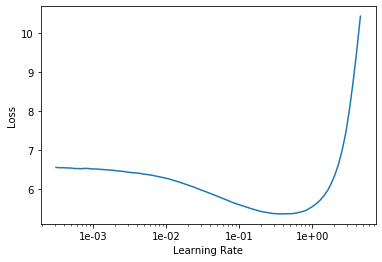

In [10]:
learn_lm.recorder.plot()

In [11]:
lr = 1e-2
# lr *= bs/48

In [12]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.046964,3.368645,0.490506,03:46
1,3.343220,2.879600,0.543189,03:53


In [13]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.649506,2.424878,0.617170,04:24
1,2.448745,2.261390,0.641093,04:26
2,2.302984,2.162119,0.656068,04:26
3,2.195410,2.080828,0.667768,04:27
4,2.073615,2.015283,0.677746,04:28
5,2.005253,1.960434,0.686349,04:28
6,1.929078,1.930863,0.691060,04:28
7,1.877568,1.926533,0.692123,04:29


In [19]:
learn_lm.save(f'{lang}fine_tuned_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_bwd')
learn_lm.data.vocab.save(path/f'{lang}fine_tuned_vocab.pkl')

In [15]:
learn_lm.data.show_batch(15)

idx,text
0,"xxup xxbos … enfer sus tratar poder para tiempo tanto esperar que tienen no personas las xxmaj . ” cola “ sólo hacer de trata se no , brother xxmaj : @nicoalessandrap rt xxup xxbos ? orden algún hay nada sé no ? xxunk xxmaj mira se como xxmaj xxbos … verl al él de burlaban se carceleros sus xxmaj . próstata la a cáncer de sufría ya , panóptico"
1,@ensustrece en xxmaj : @ensustrece rt xxup xxbos m xxunk xxmaj / t.co / / : https … l contar sin ( xxunk primera esa en anime el quedo se donde desde completo leí lo me si life re xxmaj espera xxmaj @gjoeldiaz xxbos xxunk / t.co / / : https … contraten que mediocres profesionales tener debemos reflexión tu según entonces xxmaj @clanseros @tuesta xxunk xxbos xxunk / t.co
2,"no interior es felicidad la xxmaj "" xxbos … 2s0 xxup / t.co / / : https maldad la de conocimiento mi y realidad la con encontronazo primer mi fue diadelvladivideo # el que recuerdo : @jortito19 rt xxup xxbos xxunk / t.co / / : https … m san xxmaj de gobernadores los con xxunk minsa xxmaj # del técnico equipo el y broggi xxmaj alfredo xxmaj viceministro el"
3,"mv el es seguro , favs de fav mi hace la q algo tiene breaker xxunk pero uu sé lo dificil es @nelevinee xxbos solos tienen los y huerta la a llevan los , pisos en tengan los no pueblos los en que común muy es que es , claro xxmaj xxunk xxunk xxbos ! todos a días buenos xxmaj xxbos ! ! ! xxunk quiero no , tienda en"
4,"q partidos por ser debería contrato el xxmaj @capital967 @odriozola9 xxbos cjmgfwvhv7 / t.co / / : https ehpwhilx6f / t.co / / : https ► tovar xxmaj carlos xxmaj por , hoy de carlincatura xxmaj # la pierdas te no xxmaj : @larepublica_pe rt xxup xxbos xxunk sus pican le xxmaj . veterinaria la en xxunk xxunk xxmaj xxunk xxbos pasó c mariana xxmaj esa oye , pasa xxup"
5,xxunk xxbos contentos muy veía les se hoy xxbos … h se no extranjero el en que dice también xxmaj . elecciones de adelanto el da se si económica catástrofe una anuncia hernandodesoto # : @jbcperu xxup rt xxup xxbos xxunk / t.co / / : https … xxunk alguna o empleo brindar para cargo un utilizar es nepotismo xxmaj . fernando xxmaj ver a @scheuchmartin xxunk xxbos jajjajajajaja xxup
6,"reflexionar sirvan xfavor invocó xxmaj . bsns \n \n @elgranshow_peru @miluskaeskenazi @elgranshow_peru @leon30013 : xxunk rt xxup xxbos . ptmr 😂 5 xxrep 😨 4 xxrep publicación una a like di le a 15 xxrep a xxbos … exdirect , graña xxmaj hernando xxmaj y josé xxmaj de compromiso el materializado ha se no , fecha la hasta , que admite vela xxmaj rafael xxmaj fiscal xxmaj : @manifiesto_peru"
7,: @waykaperu rt xxup xxbos . democracia haya apenas completamente eliminados ser deben venezuela xxmaj en hay que politiqueros viejos los todos xxmaj xxbos ️ ❤ ! ! xxunk y valoremos xxmaj . familia la a tiempo dedicarle como nada xxmaj xxbos ” xxunk # freud a introducir para @buenafuente y @berto_romero a pongan te filosofía en que xxmaj : xxunk “ ? 6 xxrep xxbos g dlc4ep596 / t.co
8,"en empate el marcó rodríguez xxmaj federico xxmaj ! blanquiazul xxup vamos xxup ¡ ! l o 19 xxrep g ¡ . pt xxup ' ️41 ⏱ : @clubaloficial rt xxup xxbos … po custodiados . portuguesa xxmaj , araure xxmaj de hotel importante en alojados están rusos oficiales 42 1.- \n ! ! ! alerta xxup . hora xxup última xxup : @carlosortegactv rt xxup xxbos … hasta"
9,"ayuda no monto este que consciente ser debe @sportboys hincha el xxmaj : @diegosotomayor7 rt xxup xxbos xxunk / t.co / / : https título el asegurado está casi ya , marquez xxmaj # grande xxmaj : xxunk rt xxup xxbos excelente xxmaj @elvisocc xxbos . humor mal de o triste ponerme , estresarme sin entero día un pasar a llegar es sexual fantasía mi xxmaj : @tipicoarroba rt xxup"


### Classifier

In [21]:
import pickle as pkl
with open(path/f'{lang}fine_tuned_vocab.pkl', "rb") as input_file:
    lm_vocab = pkl.load(input_file)

In [25]:
lm_vocab[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/',
 ':',
 'de',
 'rt',
 ',',
 '…',
 '.',
 'que',
 'la',
 't.co',
 'https']

In [30]:
len(lm_vocab)

50144

In [104]:
learn_lm.data.vocab.

In [31]:
data_clas = (TextList.from_df(pd.concat([train_df, gen_df, val_df]), path, vocab=learn_lm.data.vocab, cols='tweet')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1, backwards=True))

data_clas.save(f'{lang}_textlist_class_bwd')

In [36]:
data_clas = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)

In [37]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_bwd')
learn_c.freeze()

In [38]:
learn_c.lr_find(start_lr=1e-4, end_lr=1e1-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


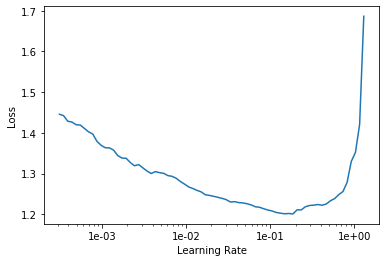

In [39]:
learn_c.recorder.plot()

In [40]:
lr=2e-2
lr *= bs/48

In [41]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.134547,1.076770,0.550974,0.387504,00:01
1,1.061237,1.021376,0.579611,0.434643,00:01


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

In [42]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,1.076512,1.030455,0.577320,0.434658,00:01
1,0.980033,0.979069,0.594502,0.438224,00:01


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

In [43]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.904001,0.989793,0.602520,0.440363,00:02
1,0.745293,1.016848,0.612829,0.482412,00:02


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio

In [44]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.590349,1.073573,0.607102,0.477080,00:03


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [45]:
learn_c.save(f'{lang}clas_bwd')

## Test Submission

In [46]:
df = pd.read_csv(path/'test_labels.csv')

In [88]:
test_df = pd.read_csv(path/'test.csv')
test_df.loc[pd.isna(test_df.tweet),'tweet']='NA'
test_df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])

In [48]:
test_df.head()

,label,tweet
0,0,@LonelySoad mientras que no te pillen la prime...
1,1,@ceemeese ya era hora de volver al csgo y deja...
2,1,@mireiaescribano justo cuando se terminan las ...
3,0,@LuisMartinez22_ pensba q iba a hacer @wxplosi...
4,1,"@Vic_Phantomhive Si lo encuentro, sin compañer..."


In [87]:
test_df.groupby(by='label').describe()

tweet                                                               
      count unique                                                top freq
label                                                                     
0       767    767  Que rápido pasa el tiempo solo se que cobro ca...    1
1       642    642  Todos nos sentimos orgullosos de tener una New...    1
2       216    216  @Oveie VUELVEEEEEEEEEEEEEEEEEE que empiezo cla...    1
3       274    274  @mpalacioses @TrofeoJose_Cano @inigoarruti @ca...    1

In [49]:
test_db  = TextList.from_df(test_df, path, cols='tweet')
len(test_db)

1899

In [50]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)

In [53]:
data_clas_bwd.add_test(test_db)

In [54]:
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()

In [55]:
learn_c_bwd.load(f'{lang}clas_bwd', purge=False)

RNNLearner(data=TextClasDataBunch;

Train: LabelList (7859 items)
x: TextList
xxbos -me caes muy bien 
  xxunk que jugar más partidas al lol con xxmaj xxunk y conmigo 
  -por qué tan xxmaj xxunk , deja de ser xxunk 
  xxunk si me muero,xxbos xxunk a. que puto mal escribo 
 
  b. me sigo xxunk help 
 
  3 . ha quedado raro el " xxunk " ahí xxup jajajaja,xxbos xxunk jajajaja la tuya y la d mucha gente seguro ! ! xxmaj pero yo no puedo sin mi melena me muero,xxbos xxmaj quiero mogollón a xxunk pero sobretodo por lo rápido que contesta a los xxunk,xxbos xxmaj vale he visto la tia xxunk su regla y me xxunk dado xxunk grima
y: CategoryList
3,0,0,1,0
Path: /home/dpalominop/.fastai/data/eswiki;

Valid: LabelList (873 items)
x: TextList
xxbos xxmaj preciosa foto de @eliasbendodo ;-) ) http : / / t.co / xxunk,xxbos xxmaj los abogados del turno de oficio abandonan por el recorte salarial http : / / t.co / xxunk,xxbos @policia . " xxmaj precaución amigo conductor que la senda es peligrosa xxrep 4 

In [96]:
preds_b, _ = learn_c_bwd.get_preds(ds_type=DatasetType.Test, ordered=False)

In [98]:
targs_b = tensor(test_df['label'].to_numpy())

In [99]:
print(len(preds_b), len(targs_b))

1899 1899


In [100]:
preds_b[:10]

tensor([[0.7274, 0.0329, 0.0514, 0.1883],
        [0.4130, 0.3176, 0.1167, 0.1528],
        [0.6345, 0.2634, 0.0929, 0.0092],
        [0.6551, 0.1201, 0.1541, 0.0707],
        [0.4996, 0.1043, 0.1756, 0.2206],
        [0.0595, 0.7913, 0.1358, 0.0135],
        [0.1219, 0.1658, 0.6888, 0.0236],
        [0.1851, 0.1882, 0.2202, 0.4064],
        [0.7667, 0.0634, 0.0808, 0.0892],
        [0.0397, 0.6114, 0.2635, 0.0855]])

In [101]:
targs_b[:10]

tensor([0, 1, 1, 0, 1, 1, 1, 0, 3, 0])

In [102]:
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.5403), tensor(0.4103))

In [103]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.6071), tensor(0.4948))